In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import math
import time
import numpy as np
import time

from torch import Tensor
from torch.nn import Parameter

from torch_geometric.nn import MessagePassing, TopKPooling, global_mean_pool
from torch_geometric.utils import degree, get_laplacian
from tqdm import trange
from torch_geometric.datasets import TUDataset
from torch_sparse import SparseTensor

In [2]:
time_stamps = {
    'epoch_time': []
}


def time_it(name):
    def inner(func):
        def wrapper(*args, **kwargs):
            start_time = time.time()
            res = func(*args, **kwargs)
            stop_time = time.time()
            if name not in time_stamps:
                time_stamps[name] = []
            time_stamps[name].append(stop_time - start_time)
            return res
        return wrapper
    return inner

In [3]:
class ComplexLinear(nn.Module):
    def __init__(self, in_features, out_features, bias=True):
        super(ComplexLinear, self).__init__()
        self.in_features = in_features
        self.out_features = out_features
        self.weight = nn.Parameter(torch.empty((out_features, in_features), dtype=torch.cfloat))
        self.bias = nn.Parameter(torch.empty(out_features, dtype=torch.cfloat)) if bias else None
        self.reset_parameters()

    def reset_parameters(self):
        nn.init.kaiming_uniform_(self.weight.real, a=math.sqrt(5))
        nn.init.kaiming_uniform_(self.weight.imag, a=math.sqrt(5))
        if self.bias is not None:
            fan_in, _ = nn.init._calculate_fan_in_and_fan_out(self.weight)
            bound = 1 / math.sqrt(fan_in)
            nn.init.uniform_(self.bias, -bound, bound)

    def forward(self, input):
        return F.linear(input, self.weight, self.bias)




class CayleyConv(MessagePassing):
    def __init__(
        self,
        r: int,
        K: int,
        in_channels: int,
        out_channels: int,
        **kwargs,
    ):
        kwargs.setdefault('aggr', 'add')
        super().__init__(**kwargs)

        assert r > 0
        assert K > 0
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.r = r
        self.K = K
        self.h = Parameter(torch.tensor(0.5, dtype=torch.float))
        self.i = Parameter(torch.tensor(0.+1.j), requires_grad=False)
        self.alpha = Parameter(torch.tensor(0.1, dtype=torch.float))
        self.real_linear = nn.Linear(in_channels, out_channels, bias=False)
        self.complex_linear = ComplexLinear(in_channels * r, out_channels, bias=False)
        self.reset_parameters()

    def reset_parameters(self):
        super().reset_parameters()
        # stdv = 1. / math.sqrt(self.in_channels)
        # self.h.data = 1.0
        # self.alpha.data = 0.0

    @time_it("forward")
    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
    ) -> Tensor:


        y_j = x
        out_0 = self.real_linear(y_j)
        out_r = []

        n_nodes = x.size(self.node_dim)
        device = edge_index.device
        edge_weight = torch.ones(edge_index.size(1), device=device)
        row, _ = edge_index
        deg = degree(row, n_nodes).to(device)
        # Laplacian
        l_index, l_weight = get_laplacian(edge_index, edge_weight, normalization=None, num_nodes=n_nodes)
        l_weight[l_index[0] == l_index[1]] -= self.alpha

        # Jacobi
        jacobi = self.calcualte_jacobi(l_index, l_weight)
        b = self._calcualte_b(l_index, l_weight)
        
        # calcualte r polynomials 
        for j in range(self.r):
            
            b_j = self.calculate_b(b, y_j)
            y_j_k = b_j

            # K jacobi iteration
            for k in range(self.K):
                # y_j ^ k+1 = J @ y_j ^ k + b_j
                y_j_k = self.propagate(l_index, x=y_j_k, jacobi=jacobi) + b_j
            y_j = y_j_k
            out_r.append(y_j)
        out_r = self.complex_linear(torch.concat(out_r, -1))
        out = out_0 + 2 * out_r.real
        return out

    def message(self, x_j: Tensor, jacobi: Tensor) -> Tensor:
        # J Y
        return jacobi.view(-1, 1) * x_j
    
    def calcualte_jacobi(self, l_index, l_weight):
        # device
        l_row, l_col = l_index

        # (hD + iI)^-1 * h
        l_dia = l_weight[l_row == l_col]
        tmp_left = 1 / (self.h * l_dia + self.i)
        tmp_left.masked_fill_(tmp_left == float('inf'), 0.+0.j)
        
        tmp_right = self.h * l_weight.type(torch.cfloat)
        tmp_right[l_row == l_col] = 0.+0.j

        jacobi = tmp_left[l_row] * tmp_right
        return -jacobi

    def _calcualte_b(self, l_index, l_weight):
        l_row, l_col = l_index

        # hL - iI
        tmp_right = (l_weight * self.h).type(self.i.dtype)
        tmp_right[l_row == l_col] -= self.i

        l_dia = l_weight[l_row == l_col]
        # (Diag(hL + iI))^-1
        tmp_left = 1 / (self.h * l_dia + self.i)
        tmp_left.masked_fill_(tmp_left == float('inf'), 0.+0.j)
        # (Diag(hL + iI))^-1 (hL - iI)
        tmp = tmp_left[l_row] * tmp_right
        tmp = torch.sparse_coo_tensor(indices=l_index, values=tmp, device=self.i.device)
        return tmp

    def calculate_b(self, b, y_j):
        return torch.matmul(b, y_j.type(torch.cfloat))
    


class CayleyConvSimple(nn.Module):
    def __init__(
        self,
        r: int,
        K: int,
        in_channels: int,
        out_channels: int,
        **kwargs,
    ):
        super().__init__(**kwargs)

        assert r > 0
        assert K > 0
        self.in_channels = in_channels
        self.out_channels = out_channels
        self.r = r
        self.K = K
        self.h = Parameter(torch.tensor(0.5, dtype=torch.float))
        self.i = Parameter(torch.tensor(0.+1.j), requires_grad=False)
        self.alpha = Parameter(torch.tensor(0.1, dtype=torch.float))
        self.real_linear = nn.Linear(in_channels, out_channels, bias=False)
        self.complex_linear = ComplexLinear(in_channels * r, out_channels, bias=False)

    @time_it("forward")
    def forward(
        self,
        x: Tensor,
        edge_index: Tensor,
    ) -> Tensor:


        y_j = x
        out_0 = self.real_linear(y_j)
        out_r = []

        n_nodes = x.size(0)
        device = edge_index.device
        edge_weight = torch.ones(edge_index.size(1), device=device)
        row, _ = edge_index
        deg = degree(row, n_nodes).to(device)
        # Laplacian
        l_index, l_weight = get_laplacian(edge_index, edge_weight, normalization=None, num_nodes=n_nodes)
        l_weight[l_index[0] == l_index[1]] -= self.alpha

        # Jacobi
        jacobi = self.calcualte_jacobi(l_index, l_weight)
        b = self._calcualte_b(l_index, l_weight)
        
        # calcualte r polynomials 
        for j in range(self.r):
            
            b_j = self.calculate_b(b, y_j)
            y_j_k = b_j

            # K jacobi iteration
            for k in range(self.K):
                # y_j ^ k+1 = J @ y_j ^ k + b_j
                y_j_k = torch.matmul(jacobi, y_j_k) + b_j
            y_j = y_j_k
            out_r.append(y_j)
        out_r = self.complex_linear(torch.concat(out_r, -1))
        out = out_0 + 2 * out_r.real
        return out
    
    def calcualte_jacobi(self, l_index, l_weight):
        # device
        l_row, l_col = l_index

        # (hD + iI)^-1 * h
        l_dia = l_weight[l_row == l_col]
        tmp_left = 1 / (self.h * l_dia + self.i)
        tmp_left.masked_fill_(tmp_left == float('inf'), 0.+0.j)
        
        tmp_right = self.h * l_weight.type(torch.cfloat)
        tmp_right[l_row == l_col] = 0.+0.j

        jacobi = -tmp_left[l_row] * tmp_right
        jacobi = torch.sparse_coo_tensor(indices=l_index, values=jacobi, device=self.i.device)
        return jacobi

    def _calcualte_b(self, l_index, l_weight):
        l_row, l_col = l_index

        # hL - iI
        tmp_right = (l_weight * self.h).type(self.i.dtype)
        tmp_right[l_row == l_col] -= self.i

        l_dia = l_weight[l_row == l_col]
        # (Diag(hL + iI))^-1
        tmp_left = 1 / (self.h * l_dia + self.i)
        tmp_left.masked_fill_(tmp_left == float('inf'), 0.+0.j)
        # (Diag(hL + iI))^-1 (hL - iI)
        tmp = tmp_left[l_row] * tmp_right
        tmp = torch.sparse_coo_tensor(indices=l_index, values=tmp, device=self.i.device)
        return tmp

    def calculate_b(self, b, y_j):
        return torch.matmul(b, y_j.type(torch.cfloat))



In [4]:

class CayleyNet(nn.Module):
    def __init__(self, n_conv, r, K, feature_dim, hidden_dim, output_dim):
        super(CayleyNet, self).__init__()
        convs = []
        for i in range(n_conv):
            # convs.append(CayleyConv(r, K, feature_dim if i == 0 else hidden_dim, hidden_dim))
            convs.append(CayleyConvSimple(r, K, feature_dim if i == 0 else hidden_dim, hidden_dim))
            convs.append(nn.ReLU())
        self.convs = nn.ModuleList(convs)
        # self.caley_conv = CayleyConv(r, K, feature_dim, hidden_dim)
        self.pool = TopKPooling(hidden_dim, ratio=0.9)
        self.lin = nn.Linear(hidden_dim, output_dim)


    def forward(self, x, edge_index):
        for i in range(0, len(self.convs), 2):
            conv = self.convs[i]
            relu = self.convs[i+1]
            x = conv(x, edge_index)
            x = relu(x)

        x, edge_index, _, batch, _, _ =  self.pool(x, edge_index)

        x = global_mean_pool(x, batch) 

        x = F.dropout(x, p=0.2, training=self.training)
        x = self.lin(x)
        
        return x

In [5]:
dataset = TUDataset(root='data/TUDataset', name='MUTAG')
#DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
DEVICE = 'cpu'
N_CONV = 1
model = CayleyNet(n_conv=N_CONV, r=5, K=10, feature_dim=7, hidden_dim=64, output_dim=dataset.num_classes).to(DEVICE)
optimizer = torch.optim.Adam(model.parameters(), lr=0.01)
criterion = torch.nn.CrossEntropyLoss()
train_dataset = dataset[:150]
test_dataset = dataset[150:]
model.train()
h_list = []
alpha_list = []
loss_list = []

for key in time_stamps:
    time_stamps[key].clear()
time_stamps['epoch_time'] = []
for epoch in range(10):
    epoch_start_time = time.time() 
    
    losses = []
    for data in train_dataset:
        # # 数据加载时间
        # start_time = time.time()
        # data = data.to(DEVICE)
        # time_stamps['data_loading'].append(time.time() - start_time)

        # # 前向传播时间
        # start_time = time.time()
        # out = model(data.x, data.edge_index)
        # time_stamps['forward_pass'].append(time.time() - start_time)

        # # 损失计算时间
        # start_time = time.time()
        # loss = criterion(out, data.y)
        # time_stamps['loss_calculation'].append(time.time() - start_time)

        # # 反向传播时间
        # start_time = time.time()
        # loss.backward()
        # time_stamps['backward_pass'].append(time.time() - start_time)

        # losses.append(loss.cpu().item())

        # # 优化器更新时间
        # start_time = time.time()
        # optimizer.step()
        # optimizer.zero_grad()
        # time_stamps['optimization'].append(time.time() - start_time)

        data = data.to(DEVICE)
        out = model(data.x, data.edge_index)
        loss = criterion(out, data.y)
        loss.backward()
        losses.append(loss.cpu().item())
        optimizer.step()
        optimizer.zero_grad()    

    h_list.append([l.h.data.cpu().item() for i, l in enumerate(model.convs) if i % 2 == 0])
    alpha_list.append([l.alpha.data.cpu().item() for i, l in enumerate(model.convs) if i % 2 == 0])
    epoch_loss = np.mean(losses)
    loss_list.append(epoch_loss)
    losses = []
    
    epoch_time = time.time() - epoch_start_time
    time_stamps['epoch_time'].append(epoch_time)

    print(f"Epoch {epoch+1} Loss: {epoch_loss}")
    print(f"Epoch {epoch+1} Total Time: {epoch_time:.2f} seconds")


for key, values in time_stamps.items():
    if not len(values):
        continue
    sum_time = sum(values) 
    print(f"{key} time per epoch: {sum_time / 10:.4f} seconds")
    time_stamps[key].clear()


model.eval()
correct = 0
with torch.no_grad():
    for data in test_dataset:  
        data = data.to(DEVICE)
        out = model(data.x, data.edge_index)  
        pred = out.argmax(dim=1) 
        correct += int((pred == data.y).sum())  
print("{} test accuracy".format(correct / len(test_dataset))) 

Epoch 1 Loss: 0.6276322581370671
Epoch 1 Total Time: 1.95 seconds
Epoch 2 Loss: 0.6427002867342283
Epoch 2 Total Time: 1.81 seconds
Epoch 3 Loss: 0.5296948228031397
Epoch 3 Total Time: 1.86 seconds
Epoch 4 Loss: 0.5841249328367606
Epoch 4 Total Time: 1.96 seconds
Epoch 5 Loss: 0.5080524619901553
Epoch 5 Total Time: 1.83 seconds
Epoch 6 Loss: 0.374804569085439
Epoch 6 Total Time: 1.82 seconds
Epoch 7 Loss: 0.32923119932456757
Epoch 7 Total Time: 1.81 seconds
Epoch 8 Loss: 0.38703757875152706
Epoch 8 Total Time: 1.82 seconds
Epoch 9 Loss: 0.31745247364139384
Epoch 9 Total Time: 1.79 seconds
Epoch 10 Loss: 0.2683780026427257
Epoch 10 Total Time: 1.93 seconds
epoch_time time per epoch: 1.8600 seconds
forward time per epoch: 0.3803 seconds
0.7631578947368421 test accuracy


In [14]:
time_stamps

{'epoch_time': []}

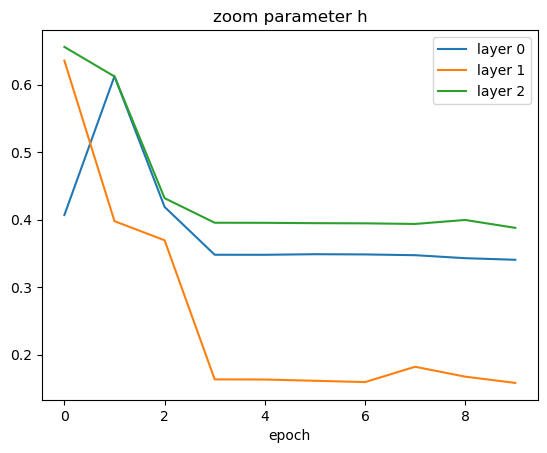

In [5]:
import matplotlib.pyplot as plt

for i in range(N_CONV):
    h_s = [h[i] for h in h_list]
    plt.plot(range(10), h_s, label=f"layer {i}")
plt.legend()
plt.title("zoom parameter h")
plt.xlabel("epoch")
plt.show()

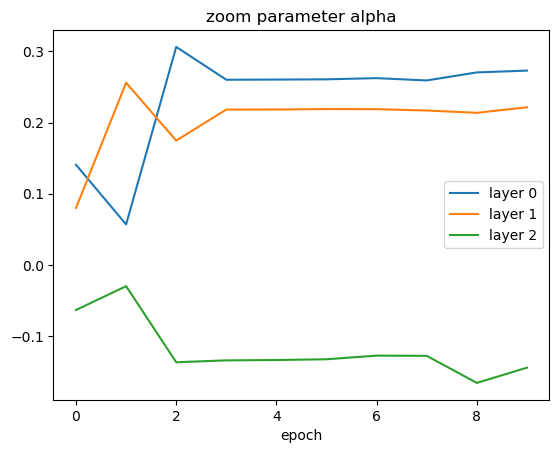

In [6]:
for i in range(N_CONV):
    a_s = [a[i] for a in alpha_list]
    plt.plot(range(10), a_s, label=f"layer {i}")
plt.legend()
plt.title("zoom parameter alpha")
plt.xlabel("epoch")
plt.show()